In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

import numpy as np
from tqdm.auto import tqdm

from agent import HandcraftedAgent


capacity = {"episodic": 16, "semantic": 16, "short": 1}

config = {
    "question_prob": 1.0,
    "seed": 42,
    "terminates_at": 99,
}

results = {}

for memory_management_policy in ["random", "generalize"]:
    for qa_policy in ["random", "episodic_semantic"]:
        for explore_policy in ["random", "avoid_walls"]:
            for pretrain_semantic in [False, True]:
                key = (
                    memory_management_policy,
                    qa_policy,
                    explore_policy,
                    pretrain_semantic,
                )
                if key not in results:
                    results[key] = []
                print(key)

                for seed in tqdm([0, 1, 2, 3, 4]):
                    config["seed"] = seed

                    agent = HandcraftedAgent(
                        env_str="room_env:RoomEnv-v2",
                        env_config=config,
                        memory_management_policy=memory_management_policy,
                        qa_policy=qa_policy,
                        explore_policy=explore_policy,
                        num_samples_for_results=10,
                        capacity=capacity,
                        pretrain_semantic=pretrain_semantic,
                    )
                    agent.test()
                    to_append = (np.mean(agent.scores), np.std(agent.scores))
                    print(to_append)
                    results[key].append(to_append)


In [4]:
print(
    f"{'memory mgmt':<20}{'qa':<20}{'explore':<20}{'pretrain_semantic':<20}{'mean':<10}{'std':<10}"
)
print(f"-" * 110)
for key, val in results.items():
    print(
        f"{str(key[0]):<20}{str(key[1]):<20}{str(key[2]):<20}{str(key[3]):<20}{round(np.mean([v[0] for v in val]), 2):<10}{round(np.std([v[0] for v in val]), 2):<10}"
    )

# scratch        58.48  +-  4.17
# pretrain       51.76  +-  7.28

memory mgmt         qa                  explore             pretrain_semantic   mean      std       
--------------------------------------------------------------------------------------------------------------
random              random              random              False               15.08     3.43      
random              random              random              True                18.96     3.06      
random              random              avoid_walls         False               15.04     4.05      
random              random              avoid_walls         True                19.64     2.19      
random              episodic_semantic   random              False               50.6      2.85      
random              episodic_semantic   random              True                57.76     2.76      
random              episodic_semantic   avoid_walls         False               52.36     1.18      
random              episodic_semantic   avoid_walls         True                5

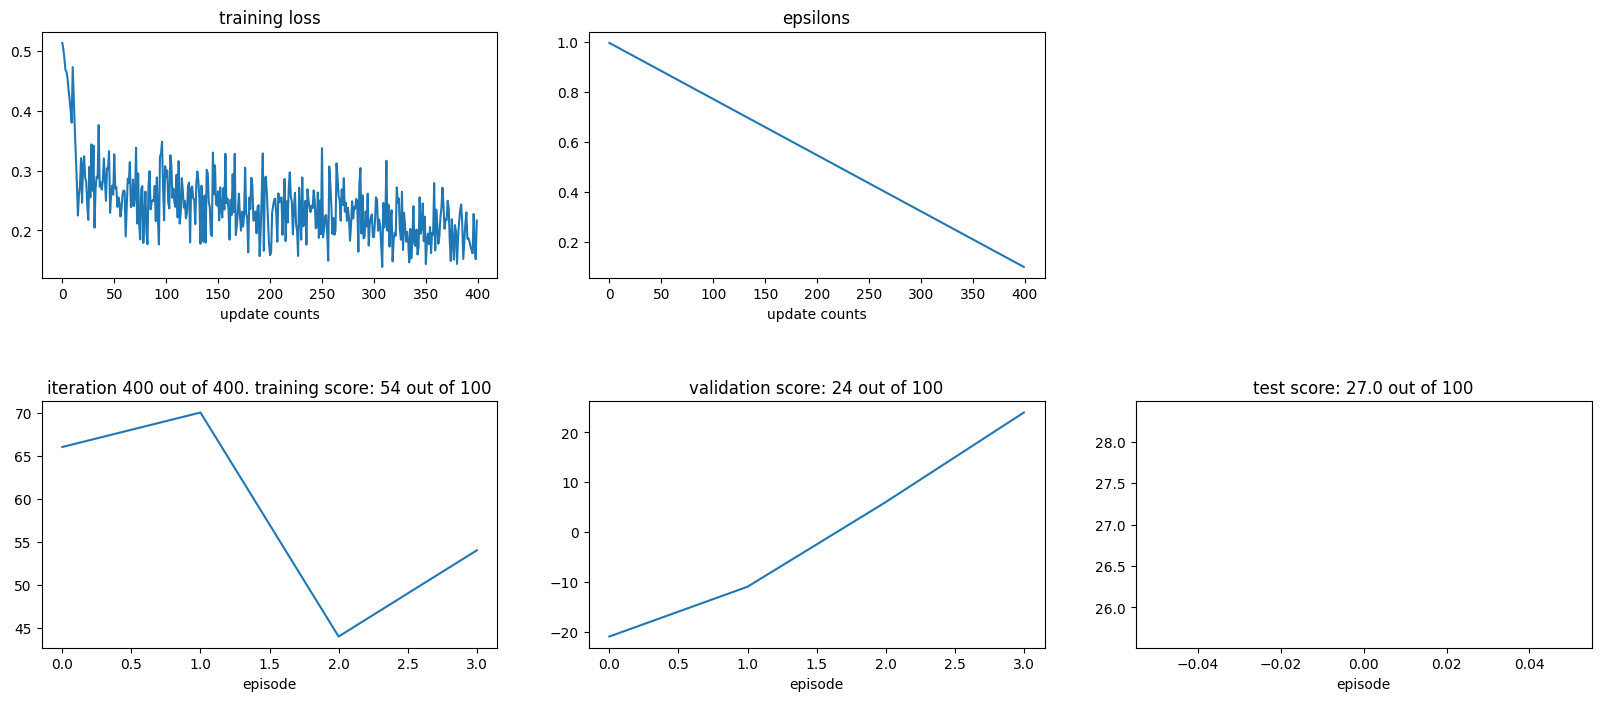

In [2]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent.dqn import DQNExploreAgent

for pretrain_semantic in [True, False]:
    for test_seed in [0, 1, 2, 3, 4]:
        # parameters
        all_params = {
            "env_str": "room_env:RoomEnv-v2",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 100 * 4,
            "gamma": 0.65,
            "capacity": {"episodic": 16, "semantic": 16, "short": 1},
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "n_actions": 5,
                "embedding_dim": 32,
                "v1_params": None,
                "v2_params": {},
            },
            "num_iterations": 100 * 4,
            "replay_buffer_size": 128 * 10,
            "warm_start": 128 * 10,
            "batch_size": 128,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_validation": True,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
        }

        agent = DQNExploreAgent(**all_params)
        agent.train()


In [120]:
from glob import glob
from explicit_memory.utils import read_yaml

results = {"pretrain": [], "scratch": []}
for foo in glob("./training_results/*/*train.yaml"):
    bar = read_yaml(foo)
    # print(foo, bar["test_seed"], bar["pretrain_semantic"])

    foo_ = foo.replace("train.yaml", "results.yaml")

    bar_ = read_yaml(foo_)
    if bar["pretrain_semantic"]:
        results["pretrain"].append(bar_["test_score"])
    else:
        results["scratch"].append(bar_["test_score"])


foo = [foo["mean"] for foo in results["scratch"]]
print(f"{'scratch':<15}{round(np.mean(foo), 2)}  +-  {round(np.std(foo), 2)}")

foo = [foo["mean"] for foo in results["pretrain"]]
print(f"{'pretrain':<15}{round(np.mean(foo), 2)}  +-  {round(np.std(foo), 2)}")

scratch        58.48  +-  4.17
pretrain       51.76  +-  7.28
